In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_masks.csv', 'train_masks', 'metadata.csv', 'sample_submission.csv', 'train']


In [2]:
import matplotlib.pyplot as plt
from skimage import io, transform
import cv2
import tensorflow as tf

In [3]:
FAST_RUN = False
FAST_PREDICT = True
IMAGE_WIDTH=128
IMAGE_HEIGHT = 128
CHANNEL = 3
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)
mask_shape = (IMAGE_WIDTH, IMAGE_HEIGHT)
image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=10
epochs=3

In [4]:
metadata = pd.read_csv("../input/metadata.csv")
train_masks = pd.read_csv("../input/train_masks.csv")
testdata = pd.read_csv("../input/sample_submission.csv")

In [5]:
print(train_masks.shape)
print(testdata.shape)

(5088, 2)
(100064, 2)


In [6]:
if FAST_RUN:
    epochs=1
    train_masks = train_masks.sample(1000).reset_index()

if FAST_PREDICT:
    test_data = testdata.sample(batch_size).reset_index()

In [7]:
train_masks.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [8]:
metadata.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [9]:
testdata.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [10]:
filenames = train_masks.img.str.split(".")
maskfilenames = filenames.str[0] + "_mask.gif"
train_masks["img_mask"] = maskfilenames
train_masks["angle"] = filenames.str[0].str.split("_").str[1].astype(int)
train_masks.head()

,img,rle_mask,img_mask,angle
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc_01_mask.gif,1
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc_02_mask.gif,2
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc_03_mask.gif,3
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc_04_mask.gif,4
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc_05_mask.gif,5


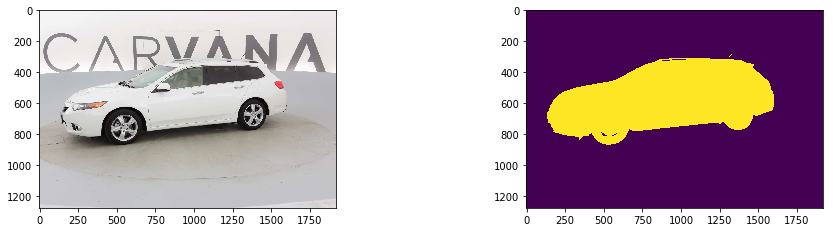

In [11]:
sample = train_masks.sample()

fig = plt.figure(figsize=(16, 8))
for index, s in sample.iterrows():
    original_image = io.imread('../input/train/' + s.img)
    masked_image = io.imread('../input/train_masks/' + s.img_mask)
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.subplot(2, 2, 2)
    plt.imshow(masked_image)
    

In [12]:
from skimage.transform import AffineTransform, warp
def shift(image, translation_matrix):
    transformer = AffineTransform(translation=translation_matrix)
    return warp(image, transformer, mode='wrap', preserve_range=True)

In [13]:
def transform_image(original_image, mask_image):
    image = original_image
    mask = mask_image
    
    isHorizontalFlip = np.random.random() < 0.5
    isShift = np.random.random() < 0.5
    
    if isShift:
        translation_matrix = np.random.random_integers(-10, 10), np.random.random_integers(-10, 10)
        image = shift(image, translation_matrix)
        mask = shift(mask, translation_matrix)
    
    if isHorizontalFlip:
        image = image[:, ::-1]
        mask = mask[:, ::-1]
    
    return image, mask

In [14]:
np.random.random_integers(-10, 10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  """Entry point for launching an IPython kernel.


8

In [15]:
a = train_masks.groupby(np.arange(len(train_masks))//batch_size)
for i, b in a:
    print(i, b)
    break

0                    img  ...  angle
0  00087a6bd4dc_01.jpg  ...      1
1  00087a6bd4dc_02.jpg  ...      2
2  00087a6bd4dc_03.jpg  ...      3
3  00087a6bd4dc_04.jpg  ...      4
4  00087a6bd4dc_05.jpg  ...      5
5  00087a6bd4dc_06.jpg  ...      6
6  00087a6bd4dc_07.jpg  ...      7
7  00087a6bd4dc_08.jpg  ...      8
8  00087a6bd4dc_09.jpg  ...      9
9  00087a6bd4dc_10.jpg  ...     10

[10 rows x 4 columns]


In [16]:
a = np.arange(len(train_masks))//batch_size
a[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
a = np.array([[1,2,3,4], [2,3,4,1]])
a = np.expand_dims(a, axis=2)
a, a.shape

(array([[[1],
         [2],
         [3],
         [4]],
 
        [[2],
         [3],
         [4],
         [1]]]), (2, 4, 1))

In [18]:
def data_gen_small(data_dir, mask_dir, df_data, precess_batch_size, original_image_shape, mask_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, image_size, mode='constant')
                
                original_mask = io.imread(mask_dir + row.img_mask, as_gray=True)
                resized_mask = transform.resize(original_mask, image_size, mode='constant')
                
                image, mask = transform_image(resized_img, resized_mask)
                
                imgs.append(image)
                labels.append(np.expand_dims(mask, axis=2))
                
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [19]:
train_gen = data_gen_small("../input/train/", "../input/train_masks/", train_masks, batch_size, input_shape, mask_shape)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


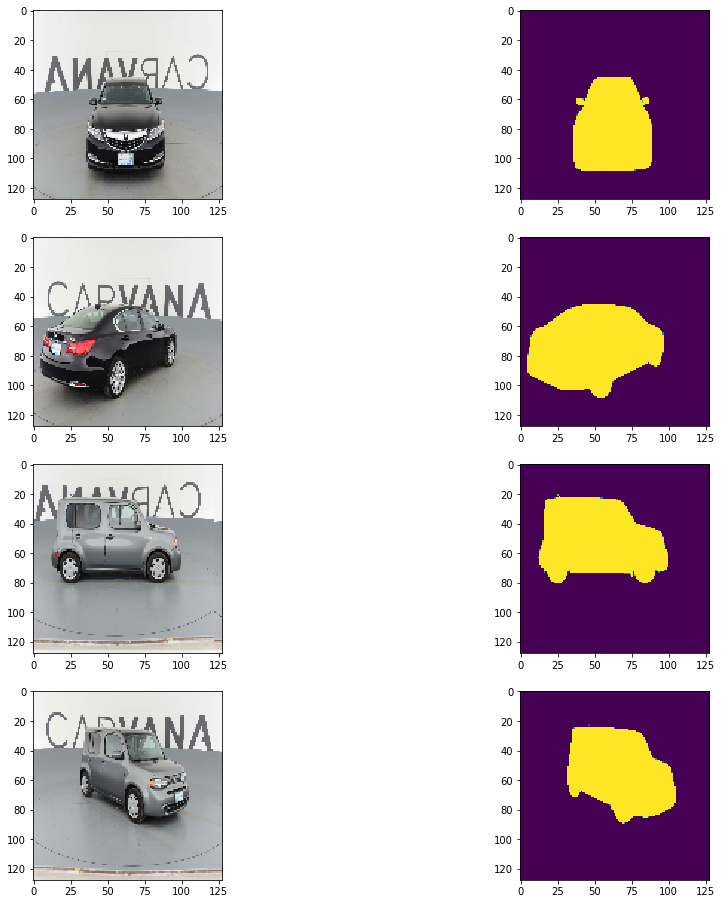

In [20]:
fig=plt.figure(figsize=(16, 16))
for i in [1, 2, 3, 4]:
    img, msk = next(train_gen)
    plt.subplot(4, 2, i*2-1)
    plt.imshow(img[0])
    plt.subplot(4, 2, i*2)
    plt.imshow(msk[0].reshape(128, 128))

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

inputs = Input(shape=input_shape)

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)

# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=outputs)


Instructions for updating:
Colocations handled automatically by placer.


In [23]:
optimizer = tf.train.RMSPropOptimizer(0.0001)
model.compile(
    optimizer='adam', 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [ ]:
steps_per_epoch=np.ceil(float(len(train_masks)) / float(batch_size)).astype(int)
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


Epoch 1/3
476/509 [===========================>..] - ETA: 1:04 - loss: 0.9083 - acc: 0.9669

In [ ]:
model.save("model.h5")

In [ ]:
def test_gen_small(data_dir, df_data, precess_batch_size, original_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, original_image_shape)
                imgs.append(resized_img)

            imgs = np.array(imgs)
            yield imgs

In [ ]:
test_gen = test_gen_small("../input/test/", testdata, batch_size, input_shape)

In [ ]:
img = next(test_gen)
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    plt.subplot(1, 4, i)
    plt.imshow(img[i-1])

In [ ]:
steps = np.ceil(float(len(testdata)) / float(batch_size)).astype(int)
y_predicted = model.predict_generator(
    test_gen, 
    steps=steps
)

In [ ]:
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    y_predict = y_predicted[i-1]
    plt.subplot(1, 4, i)
    plt.imshow(y_predict.reshape(128, 128))